##### Copyright 2020 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[link text](https://)# Binary classification of quantum states

Initial Tutorial Author : Antonio J. Martinez

Initial Tutorial Contributors : Masoud Mohseni

Initial Tutorial Created : 2020-Feb-14

Initial Tutorial Last updated : 2020-Feb-29

---

Current Experiment Author : Anneliese Brei

Current Experiment Created : 2022-Jan-3

Current Experiment Last updated : 2022-Jan-3

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/binary_classifier/binary_classifier.ipynb)

An elementary learning task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), a supervised task in which the learner is to distinguish which of two classes a given datapoint has been drawn from.  Here, using ideas from the paper [Universal discriminative quantum neural networks](https://arxiv.org/abs/1805.08654) in the one-qubit setting, we train a hybrid quantum-classical neural network to distinguish between quantum data sources.

## Import dependencies

In [ ]:
!pip install --upgrade tensorflow
!pip install qutip

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import cirq
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Quantum dataset
For our quantum dataset, you will generate two blobs on the surface of the Bloch sphere.  The task will be to learn a model to distinguish members of these blobs.  To do this, you first select two axes in the X-Z plane of the block sphere, then select random points uniformly distributed around them:

In [ ]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

In [ ]:
def build_model(theta_a, theta_b, num_samples):

  qubit = cirq.GridQubit(0, 0)

  # Build the quantum model layer 1
  theta = sympy.Symbol('theta')
  q_model = cirq.Circuit(cirq.ry(theta)(qubit))
  q_data_input = tf.keras.Input(
      shape=(), dtype=tf.dtypes.string)
  expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
  expectation_output = expectation(q_data_input)

  # Attach the classical SoftMax classifier
  classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
  classifier_output = classifier(expectation_output)
  model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

  # Standard compilation for classification
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model, qubit

In [ ]:
# Constants
theta_a = 1
theta_b = 4
num_samples = 500 # Number of datapoints for training and for testing
iterations = 10
num_epochs = 15

Test effect of increasing the number of samples for
1. Training
2. Testing

In [ ]:
#history_200 = []
#history_300 = []
#history_400 = []
#history_500 = []

#for i in range(5):

  #qubit_200 = cirq.GridQubit(0, 0)
  #model_200 = build_model(qubit_200, theta_a, theta_b, 200)

  #q_data_200, labels_200, bloch_p_200 = generate_dataset(qubit_200, theta_a, theta_b, 200)
  #history = model_200.fit(x=q_data_200, y=labels_200, epochs=1, verbose=0)
  #print("history with 200 training data points :", history.history['loss'])
  #history_200.append(history.history['loss'][-1])

  #qubit_300 = cirq.GridQubit(0, 0)
  #model_300 = build_model(qubit_300, theta_a, theta_b, 300)
  #q_data_300, labels_300, bloch_p_300 = generate_dataset(qubit_300, theta_a, theta_b, 300)
  #history = model_300.fit(x=q_data_300, y=labels_300, epochs=1, verbose=0)
  #print("history with 300 training data points :", history.history['loss'])
  #history_300.append(history.history['loss'][-1])

#plt.plot(history_200, label="200 training data points")
#plt.plot(history_300, label="300 training data points")
#plt.title("Learning to classify quantum data")
#plt.xlabel("Size of training data set")
#plt.ylabel("Error in testing classification")
#plt.show()

## 1-Node Framework
Implement Binary Classification in a federated learning framework using 1 (global) model run by 1 simulator.

In [ ]:
# Model 0 (Global)
model0, qubit0 = build_model(theta_a, theta_b, num_samples)

In [ ]:
loss1 = []       # Loss value from each epoch
accuracy1 = []   # Accuracy % of each epoch

for round in range(iterations):

  # Train initial global model
  q_data0, labels0, bloch_p0 = generate_dataset(qubit0, theta_a, theta_b, num_samples)
  history0 = model0.fit(x=q_data0, y=labels0, epochs=num_epochs, verbose=0)

  # Test updated global model for metrics
  qubit = cirq.GridQubit(0, 0)
  test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)

  #print("Evaluate global model on the testing data set")
  test_results = model0.evaluate(test_data,test_labels, batch_size=500)

  loss1.append(test_results[0])        # Save loss value of each round
  accuracy1.append(test_results[1])    # Save accuracy of each round

print("Loss:", loss1)
print("Accuracy:", accuracy1)

1/1 [==============================] - 0s 89ms/step - loss: 1.2211e-05 - accuracy: 1.0000
Loss: [0.00041929332655854523, 0.00016066155512817204, 9.022283484227955e-05, 6.0216334532015026e-05, 4.187168087810278e-05, 2.9212878871476278e-05, 2.3234078980749473e-05, 1.720566797303036e-05, 1.3701721400138922e-05, 1.2210669410706032e-05]
Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 2-Node Framework
Implement Binary Classification in a federated learning framework using 2 separate models run by 2 different simulators. Model 0 represents the global model. Models 1 is a client. The parameters are averaged and used to update the global model.

In [ ]:
# Create 2-node framework: 1 global model, 1 client

# Model 0 (Global)
model0, qubit0 = build_model(theta_a, theta_b, num_samples)

# Model 1 (client)
model1, qubit1 = build_model(theta_a, theta_b, num_samples)

# Train initial global model
q_data0, labels0, bloch_p0 = generate_dataset(qubit0, theta_a, theta_b, num_samples)
history0 = model0.fit(x=q_data0, y=labels0, epochs=num_epochs, verbose=0)

In [ ]:
loss2 = []       # Loss value from each iteration
accuracy2 = []   # Accuracy % of each iteration

for round in range(iterations):

  # Generate new local data for client
  q_data1, labels1, bloch_p1 = generate_dataset(qubit1, theta_a, theta_b, num_samples) 

  # Train client with local data
  history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)

  weights0 = model0.get_weights()   # Extract global weights (parameters)
  weights1 = model1.get_weights()   # Extract client weights (parameters)

  # Average weights
  avg_weights = weights0
  for j in range(len(weights0)):
    avg_weights[j] = (weights0[j] + weights1[j]) / 2
  #print("Averaged : \nMA :", avg_weights)  

  # Update weights
  model0.set_weights(avg_weights)
  model1.set_weights(avg_weights)

  # Test updated global model for metrics
  qubit = cirq.GridQubit(0, 0)
  test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
  #print("Evaluate global model on the testing data set")
  test_results = model0.evaluate(test_data,test_labels, batch_size=500)

  loss2.append(test_results[0])        # Save loss value of each round
  accuracy2.append(test_results[1])    # Save accuracy of each round

print("Loss:", loss2)
print("Accuracy:", accuracy2)

1/1 [==============================] - 0s 79ms/step - loss: 3.2407e-05 - accuracy: 1.0000
Loss: [0.0006367580499500036, 0.00035957369254902005, 0.00022335514950100332, 0.00015726777201052755, 0.00010778024443425238, 8.244735363405198e-05, 6.182093784445897e-05, 5.2100138418609276e-05, 4.068455382366665e-05, 3.240720252506435e-05]
Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 3-Node Framework
Implement Binary Classification in a federated learning framework using 3 separate models run by 3 different simulators. Model 0 represents the global model. Models 1 and 2 are clients. The parameters are averaged and used to update the global model.

In [ ]:
# Create 3-node framework: 1 global model, 2 clients

# Model 0 (Global)
model0, qubit0 = build_model(theta_a, theta_b, num_samples)

# Model 1 (client)
model1, qubit1 = build_model(theta_a, theta_b, num_samples)

# Model 2 (client)
model2, qubit2 = build_model(theta_a, theta_b, num_samples)

#print(model0.summary(), "\n\n")                              # Print model summary
#tf.keras.utils.plot_model(model0, show_shapes=True, dpi=70)  # Display global model

In [ ]:
# Train initial global model
q_data0, labels0, bloch_p0 = generate_dataset(qubit0, theta_a, theta_b, num_samples)
history0 = model0.fit(x=q_data0, y=labels0, epochs=num_epochs, verbose=0)
#print("M1 :", model1.get_weights())

In [ ]:
# Run models on QFL framework 
# For each epoch: 
#   1. Generate new data for clients
#   2. Train client models on their new data
#   3. Average parameters from client models and global model
#   4. Update all models

loss3 = []       # Loss value from each iteration
accuracy3 = []   # Accuracy % of each iteration

for round in range(iterations):

  # Generate new local data for clients, D2 and D3
  q_data1, labels1, bloch_p1 = generate_dataset(qubit1, theta_a, theta_b, num_samples) 
  q_data2, labels2, bloch_p2 = generate_dataset(qubit2, theta_a, theta_b, num_samples) 

  # Train clients with local data
  history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
  history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)

  weights0 = model0.get_weights()   # Extract global weights (parameters)
  weights1 = model1.get_weights()   # Extract client weights (parameters)
  weights2 = model2.get_weights()   # Extract client weights (parameters)

  # Average weights
  avg_weights = weights0
  for j in range(len(weights0)):
    avg_weights[j] = (weights0[j] + weights1[j] + weights2[j]) / 3
  #print("Averaged : \nMA :", avg_weights)  

  # Update weights
  model0.set_weights(avg_weights)
  model1.set_weights(avg_weights)
  model2.set_weights(avg_weights)
  #print("M0 :", model0.get_weights())

  # Test updated global model for metrics
  qubit = cirq.GridQubit(0, 0)
  test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
  #print("Evaluate global model on the testing data set")
  test_results = model0.evaluate(test_data,test_labels, batch_size=500)

  loss3.append(test_results[0])        # Save loss value of each round
  accuracy3.append(test_results[1])    # Save accuracy of each round

print("Loss:", loss3)
print("Accuracy:", accuracy3)

1/1 [==============================] - 0s 81ms/step - loss: 6.2617e-05 - accuracy: 1.0000
Loss: [0.3092893660068512, 0.005939615424722433, 0.0009602959617041051, 0.00043442228343337774, 0.0002643026236910373, 0.0001766552886692807, 0.0001313993416260928, 9.814467921387404e-05, 8.187592175090685e-05, 6.261693488340825e-05]
Accuracy: [0.9380000233650208, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 5-Node Framework
Implement Binary Classification in a federated learning framework using 5 separate models run by 5 different simulators. Model 0 represents the global model. Models 1, 2, 3, 4 are clients. The parameters are averaged and used to update the global model.

In [ ]:
# Create 5-node framework: 1 global model, 4 clients

# Model 0 (Global)
model0, qubit0 = build_model(theta_a, theta_b, num_samples)

# Model 1 (client)
model1, qubit1 = build_model(theta_a, theta_b, num_samples)

# Model 2 (client)
model2, qubit2 = build_model(theta_a, theta_b, num_samples)

# Model 3 (client)
model3, qubit3 = build_model(theta_a, theta_b, num_samples)

# Model 4 (client)
model4, qubit4 = build_model(theta_a, theta_b, num_samples)

In [ ]:
# Train initial global model
q_data0, labels0, bloch_p0 = generate_dataset(qubit0, theta_a, theta_b, num_samples)
history0 = model0.fit(x=q_data0, y=labels0, epochs=num_epochs, verbose=0)

In [ ]:
loss5 = []       # Loss value from each iteration
accuracy5 = []   # Accuracy % of each iteration

for round in range(iterations):

  # Generate new local data for clients, D1, D2, D3, D4
  q_data1, labels1, bloch_p1 = generate_dataset(qubit1, theta_a, theta_b, num_samples) 
  q_data2, labels2, bloch_p2 = generate_dataset(qubit2, theta_a, theta_b, num_samples) 
  q_data3, labels3, bloch_p3 = generate_dataset(qubit3, theta_a, theta_b, num_samples) 
  q_data4, labels4, bloch_p4 = generate_dataset(qubit4, theta_a, theta_b, num_samples) 

  # Train clients with local data
  history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
  history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)
  history3 = model3.fit(x=q_data3, y=labels3, epochs=num_epochs, verbose=0)
  history4 = model4.fit(x=q_data4, y=labels4, epochs=num_epochs, verbose=0)

  weights0 = model0.get_weights()   # Extract global weights (parameters)
  weights1 = model1.get_weights()   # Extract client weights (parameters)
  weights2 = model2.get_weights()   # Extract client weights (parameters)
  weights3 = model3.get_weights()   # Extract client weights (parameters)
  weights4 = model4.get_weights()   # Extract client weights (parameters)

  # Average weights
  avg_weights = weights0
  for j in range(len(weights0)):
    avg_weights[j] = (weights0[j] + weights1[j] + weights2[j] + weights3[j] + weights4[j]) / 5
  #print("Averaged : \nMA :", avg_weights)  

  # Update weights
  model0.set_weights(avg_weights)
  model1.set_weights(avg_weights)
  model2.set_weights(avg_weights)
  model3.set_weights(avg_weights)
  model4.set_weights(avg_weights)
  #print("M0 :", model0.get_weights())
  #print("M1 :", model1.get_weights())
  #print("M2 :", model2.get_weights())

  # Test updated global model for metrics
  qubit = cirq.GridQubit(0, 0)
  test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
  #print("Evaluate global model on the testing data set")
  test_results = model0.evaluate(test_data,test_labels, batch_size=500)

  loss5.append(test_results[0])        # Save loss value of each round
  accuracy5.append(test_results[1])    # Save accuracy of each round

print("Loss:", loss5)
print("Accuracy:", accuracy5)

1/1 [==============================] - 0s 100ms/step - loss: 5.7044e-05 - accuracy: 1.0000
Loss: [1.526082158088684, 0.003351188264787197, 0.0006179666961543262, 0.00033411686308681965, 0.00020866132399532944, 0.0001420734915882349, 0.0001150905663962476, 9.051527740666643e-05, 7.130231824703515e-05, 5.704435534426011e-05]
Accuracy: [0.27000001072883606, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 10-Node Framework
Implement Binary Classification in a federated learning framework using 10 separate models run by 10 different simulators. Model 0 represents the global model. Models 1, 2, 3, 4, 5, 6, 7, 8, 9 are clients. The parameters are averaged and used to update the global model.

In [ ]:
# Create 10-node framework: 1 global model, 9 clients

# Model 0 (Global)
model0, qubit0 = build_model(theta_a, theta_b, num_samples)

# Model 1 (client)
model1, qubit1 = build_model(theta_a, theta_b, num_samples)

# Model 2 (client)
model2, qubit2 = build_model(theta_a, theta_b, num_samples)

# Model 3 (client)
model3, qubit3 = build_model(theta_a, theta_b, num_samples)

# Model 4 (client)
model4, qubit4 = build_model(theta_a, theta_b, num_samples)

# Model 5 (Global)
model5, qubit5 = build_model(theta_a, theta_b, num_samples)

# Model 6 (client)
model6, qubit6 = build_model(theta_a, theta_b, num_samples)

# Model 7 (client)
model7, qubit7 = build_model(theta_a, theta_b, num_samples)

# Model 8 (client)
model8, qubit8 = build_model(theta_a, theta_b, num_samples)

# Model 9 (client)
model9, qubit9 = build_model(theta_a, theta_b, num_samples)

In [ ]:
# Train initial global model
q_data0, labels0, bloch_p0 = generate_dataset(qubit0, theta_a, theta_b, num_samples)
history0 = model0.fit(x=q_data0, y=labels0, epochs=num_epochs, verbose=0)

In [ ]:
loss10 = []       # Loss value from each epoch
accuracy10 = []   # Accuracy % of each epoch

for round in range(iterations):

  # Generate new local data for clients, D1, D2, D3, D4
  q_data1, labels1, bloch_p1 = generate_dataset(qubit1, theta_a, theta_b, num_samples) 
  q_data2, labels2, bloch_p2 = generate_dataset(qubit2, theta_a, theta_b, num_samples) 
  q_data3, labels3, bloch_p3 = generate_dataset(qubit3, theta_a, theta_b, num_samples) 
  q_data4, labels4, bloch_p4 = generate_dataset(qubit4, theta_a, theta_b, num_samples) 
  q_data5, labels5, bloch_p5 = generate_dataset(qubit5, theta_a, theta_b, num_samples) 
  q_data6, labels6, bloch_p6 = generate_dataset(qubit6, theta_a, theta_b, num_samples) 
  q_data7, labels7, bloch_p7 = generate_dataset(qubit7, theta_a, theta_b, num_samples) 
  q_data8, labels8, bloch_p8 = generate_dataset(qubit8, theta_a, theta_b, num_samples)
  q_data9, labels9, bloch_p9 = generate_dataset(qubit9, theta_a, theta_b, num_samples) 

  # Train clients with local data
  history1 = model1.fit(x=q_data1, y=labels1, epochs=num_epochs, verbose=0)
  history2 = model2.fit(x=q_data2, y=labels2, epochs=num_epochs, verbose=0)
  history3 = model3.fit(x=q_data3, y=labels3, epochs=num_epochs, verbose=0)
  history4 = model4.fit(x=q_data4, y=labels4, epochs=num_epochs, verbose=0)
  history5 = model5.fit(x=q_data5, y=labels5, epochs=num_epochs, verbose=0)
  history6 = model6.fit(x=q_data6, y=labels6, epochs=num_epochs, verbose=0)
  history7 = model7.fit(x=q_data7, y=labels7, epochs=num_epochs, verbose=0)
  history8 = model8.fit(x=q_data8, y=labels8, epochs=num_epochs, verbose=0)
  history9 = model9.fit(x=q_data9, y=labels9, epochs=num_epochs, verbose=0)

  weights0 = model0.get_weights()   # Extract global weights (parameters)
  weights1 = model1.get_weights()   # Extract client weights (parameters)
  weights2 = model2.get_weights()   # Extract client weights (parameters)
  weights3 = model3.get_weights()   # Extract client weights (parameters)
  weights4 = model4.get_weights()   # Extract client weights (parameters)
  weights5 = model5.get_weights()   # Extract global weights (parameters)
  weights6 = model6.get_weights()   # Extract client weights (parameters)
  weights7 = model7.get_weights()   # Extract client weights (parameters)
  weights8 = model8.get_weights()   # Extract client weights (parameters)
  weights9 = model9.get_weights()   # Extract client weights (parameters)

  # Average weights
  avg_weights = weights0
  for j in range(len(weights0)):
    avg_weights[j] = (weights0[j] + weights1[j] + weights2[j] + weights3[j] 
                      + weights4[j] + weights5[j] + weights6[j] + weights7[j] 
                      + weights8[j] + weights9[j]) / 10
  #print("Averaged : \nMA :", avg_weights)  

  # Update weights
  model0.set_weights(avg_weights)
  model1.set_weights(avg_weights)
  model2.set_weights(avg_weights)
  model3.set_weights(avg_weights)
  model4.set_weights(avg_weights)
  model5.set_weights(avg_weights)
  model6.set_weights(avg_weights)
  model7.set_weights(avg_weights)
  model8.set_weights(avg_weights)
  model9.set_weights(avg_weights)

  # Test updated global model for metrics
  qubit = cirq.GridQubit(0, 0)
  test_data, test_labels, test_bloch_p = generate_dataset(qubit, theta_a, theta_b, 500)
  test_results = model0.evaluate(test_data,test_labels, batch_size=500)

  loss10.append(test_results[0])        # Save loss value of each round
  accuracy10.append(test_results[1])    # Save accuracy of each round

print("Loss:", loss10)
print("Accuracy:", accuracy10)

1/1 [==============================] - 0s 50ms/step - loss: 4.4396e-05 - accuracy: 1.0000
Loss: [0.2849541902542114, 0.0010850058170035481, 0.00047784269554540515, 0.00026857617194764316, 0.00017431788728572428, 0.00011921949044335634, 8.994906966108829e-05, 6.899289292050526e-05, 5.0162932893726975e-05, 4.439588519744575e-05]
Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Run frameworks

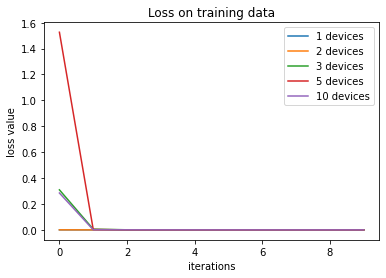

In [ ]:
plt.plot(loss1, label="1 devices")
plt.plot(loss2, label="2 devices")
plt.plot(loss3, label="3 devices")
plt.plot(loss5, label="5 devices")
plt.plot(loss10, label="10 devices")
plt.xlabel("iterations")
plt.ylabel("loss value")
plt.legend()
plt.title("Loss on training data")
plt.show()

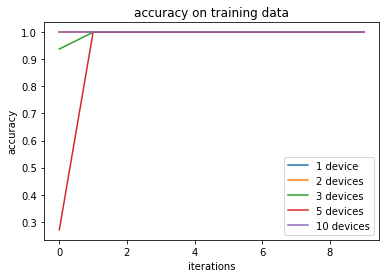

In [ ]:
plt.plot(accuracy1, label="1 device")
plt.plot(accuracy2, label="2 devices")
plt.plot(accuracy3, label="3 devices")
plt.plot(accuracy5, label="5 devices")
plt.plot(accuracy10, label="10 devices")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy on training data")
plt.show()

In [ ]:
print("Loss 1 :", loss1)
print("Loss 2 :", loss2)
print("Loss 3 :", loss3)
print("Loss 5 :", loss5)
print("Loss 10:", loss10)
print("-"*10)
print("Accuracy 1 : ", accuracy1)
print("Accuracy 2 : ", accuracy2)
print("Accuracy 3 : ", accuracy3)
print("Accuracy 5 : ", accuracy5)
print("Accuracy 10: ", accuracy10)

Loss 1 : [0.00041929332655854523, 0.00016066155512817204, 9.022283484227955e-05, 6.0216334532015026e-05, 4.187168087810278e-05, 2.9212878871476278e-05, 2.3234078980749473e-05, 1.720566797303036e-05, 1.3701721400138922e-05, 1.2210669410706032e-05]
Loss 2 : [0.0006367580499500036, 0.00035957369254902005, 0.00022335514950100332, 0.00015726777201052755, 0.00010778024443425238, 8.244735363405198e-05, 6.182093784445897e-05, 5.2100138418609276e-05, 4.068455382366665e-05, 3.240720252506435e-05]
Loss 3 : [0.3092893660068512, 0.005939615424722433, 0.0009602959617041051, 0.00043442228343337774, 0.0002643026236910373, 0.0001766552886692807, 0.0001313993416260928, 9.814467921387404e-05, 8.187592175090685e-05, 6.261693488340825e-05]
Loss 5 : [1.526082158088684, 0.003351188264787197, 0.0006179666961543262, 0.00033411686308681965, 0.00020866132399532944, 0.0001420734915882349, 0.0001150905663962476, 9.051527740666643e-05, 7.130231824703515e-05, 5.704435534426011e-05]
Loss 10: [0.2849541902542114, 0.00